<a href="https://colab.research.google.com/github/Jersae/Google-TimeSeries-workshop/blob/main/TF_Experimental_Preprocessing_for_Structured_data_classification_from_scratch.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Structured data classification from scratch

**Author:** [fchollet](https://twitter.com/fchollet)<br>
**Description:** Binary classification of structured data including numerical and categorical features.

## Introduction

This example demonstrates how to do structured data classification, starting from a raw
CSV file. Our data includes both numerical and categorical features. We will use Keras
preprocessing layers to normalize the numerical features and vectorize the categorical
ones.

Note that this example should be run with TensorFlow 2.3 or higher, or `tf-nightly`.

### The dataset

[Our dataset](https://archive.ics.uci.edu/ml/datasets/heart+Disease) is provided by the
Cleveland Clinic Foundation for Heart Disease.
It's a CSV file with 303 rows. Each row contains information about a patient (a
**sample**), and each column describes an attribute of the patient (a **feature**). We
use the features to predict whether a patient has a heart disease (**binary
classification**).

Here's the description of each feature:

Column| Description| Feature Type
------------|--------------------|----------------------
Age | Age in years | Numerical
Sex | (1 = male; 0 = female) | Categorical
CP | Chest pain type (0, 1, 2, 3, 4) | Categorical
Trestbpd | Resting blood pressure (in mm Hg on admission) | Numerical
Chol | Serum cholesterol in mg/dl | Numerical
FBS | fasting blood sugar in 120 mg/dl (1 = true; 0 = false) | Categorical
RestECG | Resting electrocardiogram results (0, 1, 2) | Categorical
Thalach | Maximum heart rate achieved | Numerical
Exang | Exercise induced angina (1 = yes; 0 = no) | Categorical
Oldpeak | ST depression induced by exercise relative to rest | Numerical
Slope | Slope of the peak exercise ST segment | Numerical
CA | Number of major vessels (0-3) colored by fluoroscopy | Both numerical & categorical
Thal | 0,1,2,3 | Categorical
Target | Diagnosis of heart disease (1 = true; 0 = false) | Target


## Setup


In [1]:
import tensorflow as tf
import numpy as np
import pandas as pd
from tensorflow import keras
from tensorflow.keras import layers


In [2]:
tf.__version__

'2.4.1'

## Preparing the data

Let's download the data and load it into a Pandas dataframe:


In [3]:
# !wget -q https://www.dropbox.com/s/hhcnjurrv46aj24/heart.csv

In [4]:
file_url = "http://storage.googleapis.com/download.tensorflow.org/data/heart.csv"
dataframe = pd.read_csv(file_url)


The dataset includes 303 samples with 14 columns per sample (13 features, plus the target
label):


In [5]:
dataframe.shape

(303, 14)

Here's a preview of a few samples:


In [6]:
dataframe.head()

,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,target
0,63,1,1,145,233,1,2,150,0,2.3,3,0,fixed,0
1,67,1,4,160,286,0,2,108,1,1.5,2,3,normal,1
2,67,1,4,120,229,0,2,129,1,2.6,2,2,reversible,0
3,37,1,3,130,250,0,0,187,0,3.5,3,0,normal,0
4,41,0,2,130,204,0,2,172,0,1.4,1,0,normal,0


In [7]:
dataframe.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 303 entries, 0 to 302
Data columns (total 14 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   age       303 non-null    int64  
 1   sex       303 non-null    int64  
 2   cp        303 non-null    int64  
 3   trestbps  303 non-null    int64  
 4   chol      303 non-null    int64  
 5   fbs       303 non-null    int64  
 6   restecg   303 non-null    int64  
 7   thalach   303 non-null    int64  
 8   exang     303 non-null    int64  
 9   oldpeak   303 non-null    float64
 10  slope     303 non-null    int64  
 11  ca        303 non-null    int64  
 12  thal      303 non-null    object 
 13  target    303 non-null    int64  
dtypes: float64(1), int64(12), object(1)
memory usage: 33.3+ KB


In [8]:
dataframe['thal'].unique()

array(['fixed', 'normal', 'reversible', '1', '2'], dtype=object)

The last column, "target", indicates whether the patient has a heart disease (1) or not
(0).

Let's split the data into a training and validation set:


In [9]:
val_dataframe = dataframe.sample(frac=0.2, random_state=1337)
train_dataframe = dataframe.drop(val_dataframe.index)

print(
    "Using %d samples for training and %d for validation"
    % (len(train_dataframe), len(val_dataframe))
)


Using 242 samples for training and 61 for validation


Let's generate `tf.data.Dataset` objects for each dataframe:


In [10]:

def dataframe_to_dataset(dataframe):
    dataframe = dataframe.copy()
    labels = dataframe.pop("target")
    ds = tf.data.Dataset.from_tensor_slices((dict(dataframe), labels))
    ds = ds.shuffle(buffer_size=len(dataframe))
    return ds


train_ds = dataframe_to_dataset(train_dataframe)
val_ds = dataframe_to_dataset(val_dataframe)


Each `Dataset` yields a tuple `(input, target)` where `input` is a dictionary of features
and `target` is the value `0` or `1`:


In [11]:
for x, y in train_ds.take(1):
    print("Input:", x)
    print("Target:", y)


Input: {'age': <tf.Tensor: shape=(), dtype=int64, numpy=59>, 'sex': <tf.Tensor: shape=(), dtype=int64, numpy=1>, 'cp': <tf.Tensor: shape=(), dtype=int64, numpy=4>, 'trestbps': <tf.Tensor: shape=(), dtype=int64, numpy=140>, 'chol': <tf.Tensor: shape=(), dtype=int64, numpy=177>, 'fbs': <tf.Tensor: shape=(), dtype=int64, numpy=0>, 'restecg': <tf.Tensor: shape=(), dtype=int64, numpy=0>, 'thalach': <tf.Tensor: shape=(), dtype=int64, numpy=162>, 'exang': <tf.Tensor: shape=(), dtype=int64, numpy=1>, 'oldpeak': <tf.Tensor: shape=(), dtype=float64, numpy=0.0>, 'slope': <tf.Tensor: shape=(), dtype=int64, numpy=1>, 'ca': <tf.Tensor: shape=(), dtype=int64, numpy=1>, 'thal': <tf.Tensor: shape=(), dtype=string, numpy=b'reversible'>}
Target: tf.Tensor(1, shape=(), dtype=int64)


Let's batch the datasets:


In [12]:
train_ds = train_ds.batch(32)
val_ds = val_ds.batch(32)


## Feature preprocessing with Keras layers


The following features are categorical features encoded as integers:

- `sex`
- `cp`
- `fbs`
- `restecg`
- `exang`
- `ca`

We will encode these features using **one-hot encoding** using the `CategoryEncoding()`
layer.

We also have a categorical feature encoded as a string: `thal`. We will first create an
index of all possible features using the `StringLookup()` layer, then we will one-hot
encode the output indices using a `CategoryEncoding()` layer.

Finally, the following feature are continuous numerical features:

- `age`
- `trestbps`
- `chol`
- `thalach`
- `oldpeak`
- `slope`

For each of these features, we will use a `Normalization()` layer to make sure the mean
of each feature is 0 and its standard deviation is 1.

Below, we define 3 utility functions to do the operations:

- `encode_numerical_feature` to apply featurewise normalization to numerical features.
- `encode_string_categorical_feature` to first turn string inputs into integer indices,
then one-hot encode these integer indices.
- `encode_integer_categorical_feature` to one-hot encode integer categorical features.


In [13]:
from tensorflow.keras.layers.experimental.preprocessing import Normalization
from tensorflow.keras.layers.experimental.preprocessing import CategoryEncoding
from tensorflow.keras.layers.experimental.preprocessing import StringLookup


def encode_numerical_feature(feature, name, dataset):
    # Create a Normalization layer for our feature
    normalizer = Normalization()

    # Prepare a Dataset that only yields our feature
    feature_ds = dataset.map(lambda x, y: x[name])
    feature_ds = feature_ds.map(lambda x: tf.expand_dims(x, -1))

    # Learn the statistics of the data
    normalizer.adapt(feature_ds)

    # Normalize the input feature
    encoded_feature = normalizer(feature)
    return encoded_feature


def encode_string_categorical_feature(feature, name, dataset):
    # Create a StringLookup layer which will turn strings into integer indices
    index = StringLookup()

    # Prepare a Dataset that only yields our feature
    feature_ds = dataset.map(lambda x, y: x[name])
    feature_ds = feature_ds.map(lambda x: tf.expand_dims(x, -1))

    # Learn the set of possible string values and assign them a fixed integer index
    index.adapt(feature_ds)

    # Turn the string input into integer indices
    encoded_feature = index(feature)

    # Create a CategoryEncoding for our integer indices
    encoder = CategoryEncoding(output_mode="binary")

    # Prepare a dataset of indices
    feature_ds = feature_ds.map(index)

    # Learn the space of possible indices
    encoder.adapt(feature_ds)

    # Apply one-hot encoding to our indices
    encoded_feature = encoder(encoded_feature)
    return encoded_feature


def encode_integer_categorical_feature(feature, name, dataset):
    # Create a CategoryEncoding for our integer indices
    encoder = CategoryEncoding(output_mode="binary")

    # Prepare a Dataset that only yields our feature
    feature_ds = dataset.map(lambda x, y: x[name])
    feature_ds = feature_ds.map(lambda x: tf.expand_dims(x, -1))

    # Learn the space of possible indices
    encoder.adapt(feature_ds)

    # Apply one-hot encoding to our indices
    encoded_feature = encoder(feature)
    return encoded_feature



## Build a model

With this done, we can create our end-to-end model:


In [14]:
# Categorical features encoded as integers
sex = keras.Input(shape=(1,), name="sex", dtype="int64")
cp = keras.Input(shape=(1,), name="cp", dtype="int64")
fbs = keras.Input(shape=(1,), name="fbs", dtype="int64")
restecg = keras.Input(shape=(1,), name="restecg", dtype="int64")
exang = keras.Input(shape=(1,), name="exang", dtype="int64")
ca = keras.Input(shape=(1,), name="ca", dtype="int64")

# Categorical feature encoded as string
thal = keras.Input(shape=(1,), name="thal", dtype="string")

# Numerical features
age = keras.Input(shape=(1,), name="age")
trestbps = keras.Input(shape=(1,), name="trestbps")
chol = keras.Input(shape=(1,), name="chol")
thalach = keras.Input(shape=(1,), name="thalach")
oldpeak = keras.Input(shape=(1,), name="oldpeak")
slope = keras.Input(shape=(1,), name="slope")

all_inputs = [
    sex,
    cp,
    fbs,
    restecg,
    exang,
    ca,
    thal,
    age,
    trestbps,
    chol,
    thalach,
    oldpeak,
    slope,
]

# Integer categorical features
sex_encoded = encode_integer_categorical_feature(sex, "sex", train_ds)
cp_encoded = encode_integer_categorical_feature(cp, "cp", train_ds)
fbs_encoded = encode_integer_categorical_feature(fbs, "fbs", train_ds)
restecg_encoded = encode_integer_categorical_feature(restecg, "restecg", train_ds)
exang_encoded = encode_integer_categorical_feature(exang, "exang", train_ds)
ca_encoded = encode_integer_categorical_feature(ca, "ca", train_ds)

# String categorical features
thal_encoded = encode_string_categorical_feature(thal, "thal", train_ds)

# Numerical features
age_encoded = encode_numerical_feature(age, "age", train_ds)
trestbps_encoded = encode_numerical_feature(trestbps, "trestbps", train_ds)
chol_encoded = encode_numerical_feature(chol, "chol", train_ds)
thalach_encoded = encode_numerical_feature(thalach, "thalach", train_ds)
oldpeak_encoded = encode_numerical_feature(oldpeak, "oldpeak", train_ds)
slope_encoded = encode_numerical_feature(slope, "slope", train_ds)




In [15]:
all_features = layers.concatenate(
    [
        sex_encoded,
        cp_encoded,
        fbs_encoded,
        restecg_encoded,
        exang_encoded,
        slope_encoded,
        ca_encoded,
        thal_encoded,
        age_encoded,
        trestbps_encoded,
        chol_encoded,
        thalach_encoded,
        oldpeak_encoded,
    ]
)
x = layers.Dense(32, activation="relu")(all_features)
x = layers.Dropout(0.5)(x)
output = layers.Dense(1, activation="sigmoid")(x)

model = keras.Model(all_inputs, output)

model.compile("adam", "binary_crossentropy", metrics=["accuracy"])

Let's visualize our connectivity graph:


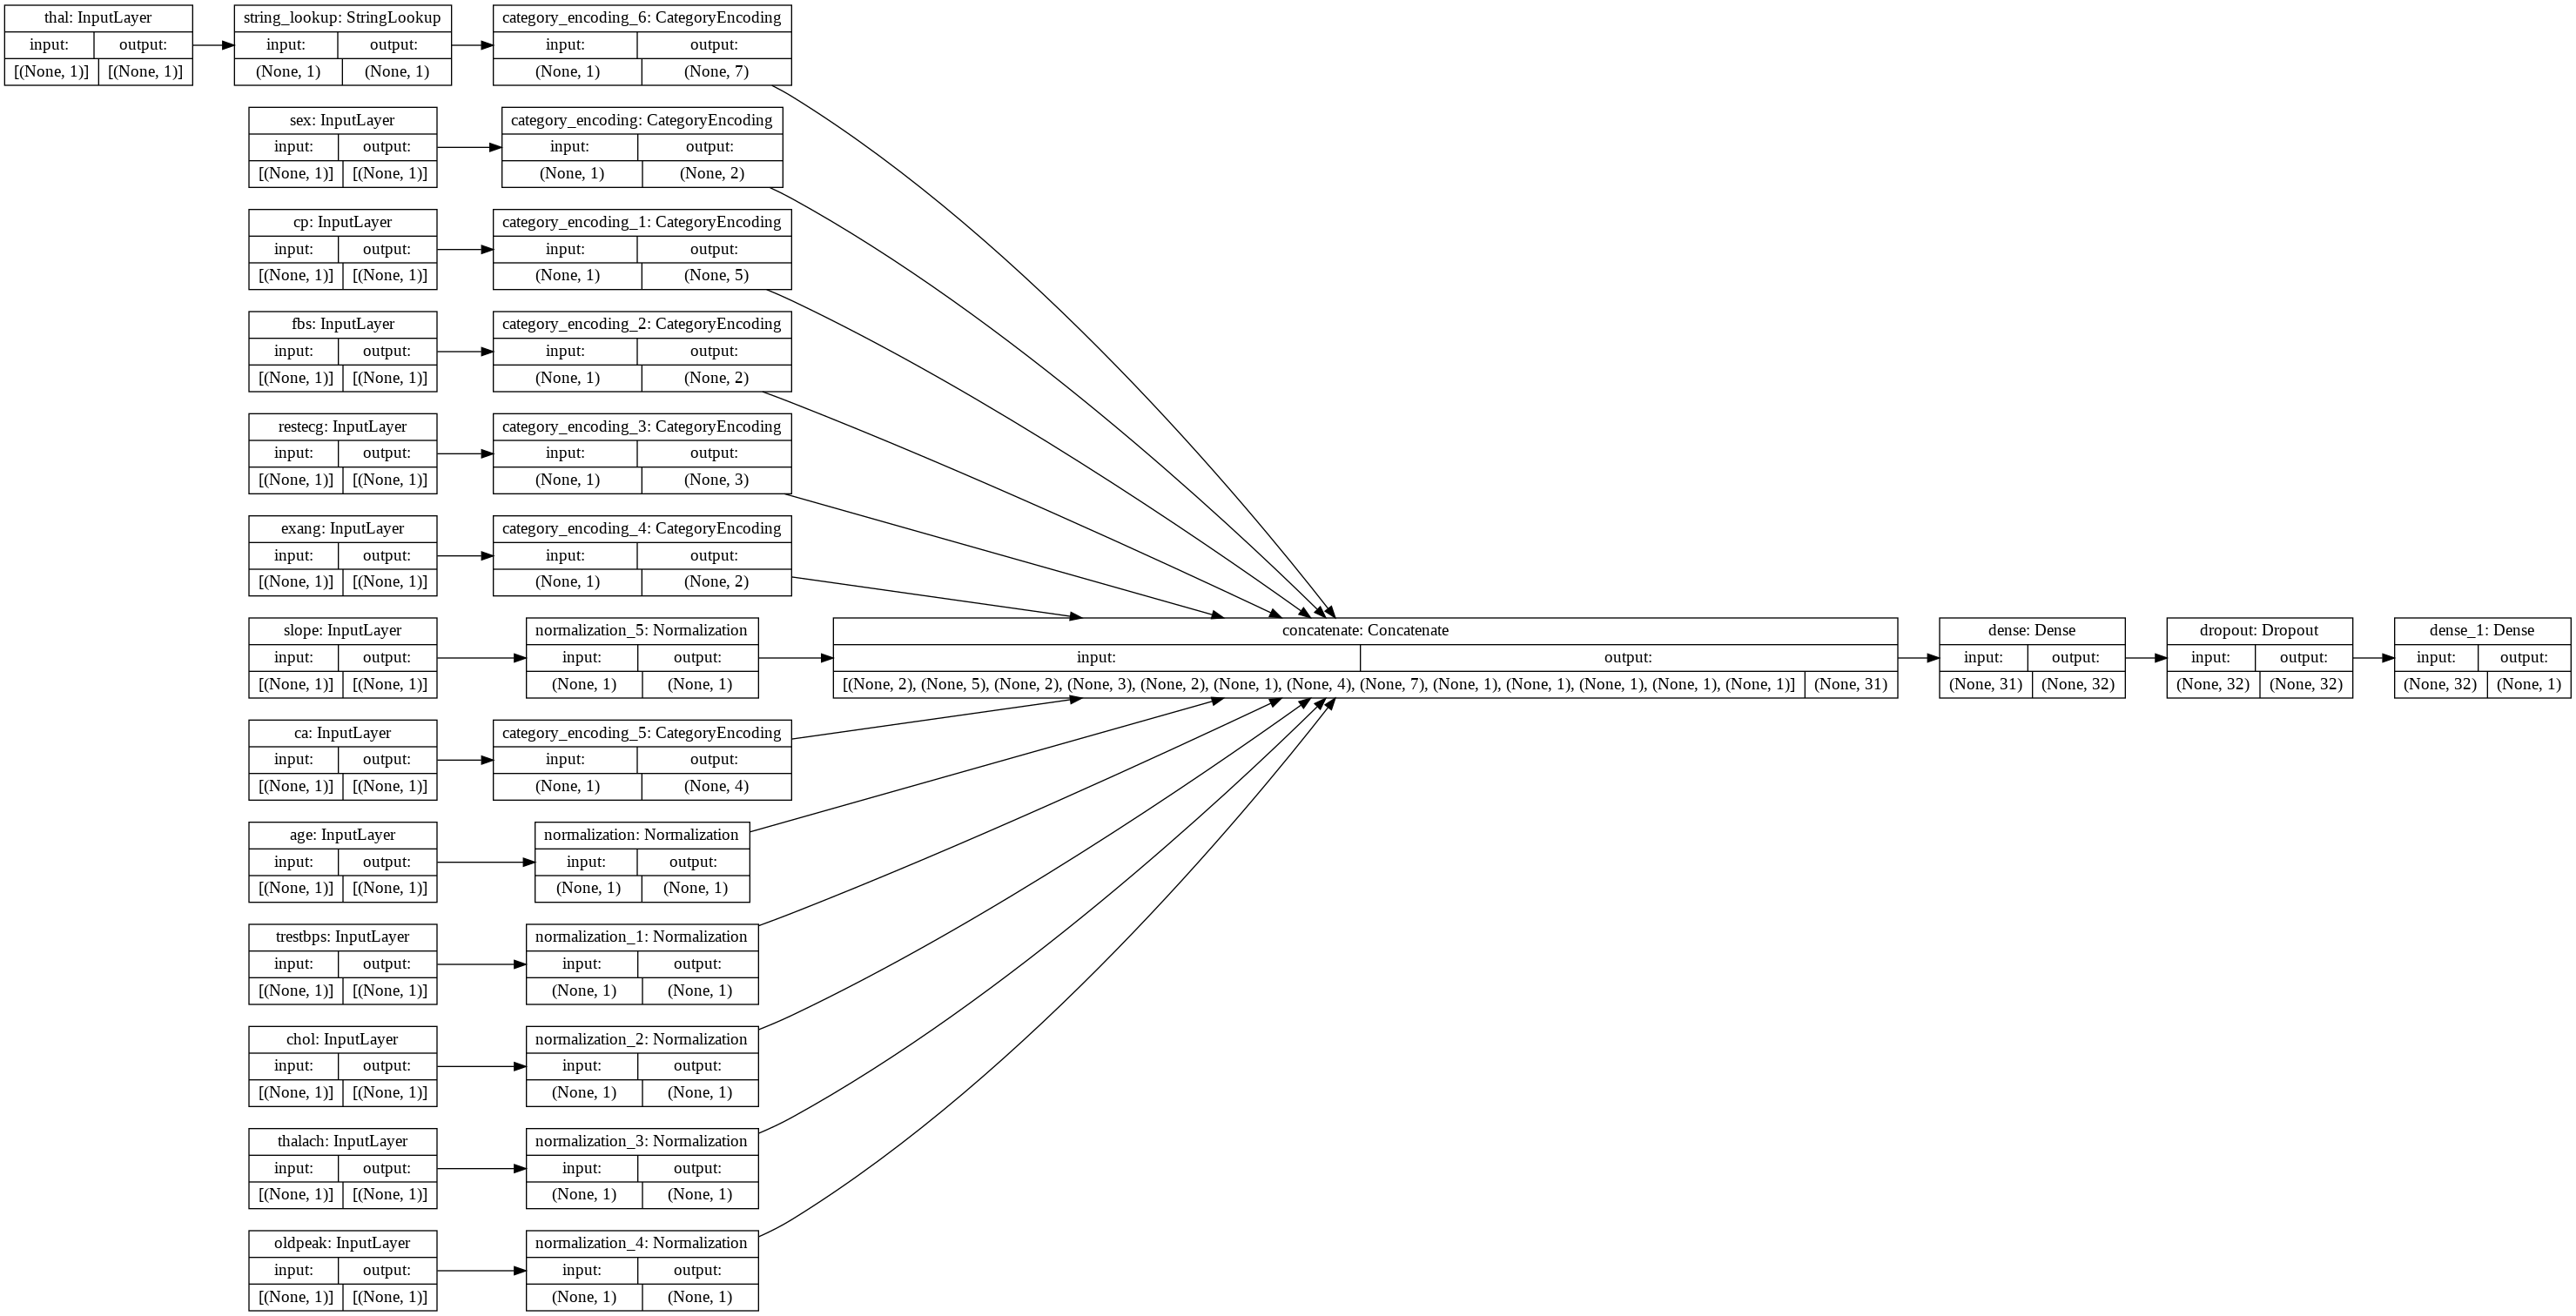

In [16]:
# `rankdir='LR'` is to make the graph horizontal.
keras.utils.plot_model(model, show_shapes=True, rankdir="LR")


## Train the model


In [17]:
model.fit(train_ds, epochs=50, validation_data=val_ds)


Epoch 1/50
8/8 [==============================] - 2s 110ms/step - loss: 0.8612 - accuracy: 0.3591 - val_loss: 0.7813 - val_accuracy: 0.3279
Epoch 2/50
8/8 [==============================] - 0s 8ms/step - loss: 0.7744 - accuracy: 0.4843 - val_loss: 0.7248 - val_accuracy: 0.4262
Epoch 3/50
8/8 [==============================] - 0s 7ms/step - loss: 0.7258 - accuracy: 0.5597 - val_loss: 0.6778 - val_accuracy: 0.4918
Epoch 4/50
8/8 [==============================] - 0s 8ms/step - loss: 0.6421 - accuracy: 0.6314 - val_loss: 0.6394 - val_accuracy: 0.6393
Epoch 5/50
8/8 [==============================] - 0s 8ms/step - loss: 0.6518 - accuracy: 0.6595 - val_loss: 0.6065 - val_accuracy: 0.7049
Epoch 6/50
8/8 [==============================] - 0s 7ms/step - loss: 0.5772 - accuracy: 0.7064 - val_loss: 0.5774 - val_accuracy: 0.7541
Epoch 7/50
8/8 [==============================] - 0s 7ms/step - loss: 0.5621 - accuracy: 0.7669 - val_loss: 0.5517 - val_accuracy: 0.7705
Epoch 8/50
8/8 [================

We quickly get to above 80% validation accuracy.


## Inference on new data

To get a prediction for a new sample, you can simply call `model.predict()`. There are
just two things you need to do:

1. wrap scalars into a list so as to have a batch dimension (models only process batches
of data, not single samples)
2. Call `convert_to_tensor` on each feature


In [18]:
sample = {
    "age": 60,
    "sex": 1,
    "cp": 1,
    "trestbps": 145,
    "chol": 233,
    "fbs": 1,
    "restecg": 2,
    "thalach": 150,
    "exang": 0,
    "oldpeak": 2.3,
    "slope": 3,
    "ca": 0,
    "thal": "fixed",
}

input_dict = {name: tf.convert_to_tensor([value]) for name, value in sample.items()}
model.predict(input_dict)


array([[0.1830363]], dtype=float32)